# Exercício 2
## 3ª Lista de Fundamentos em Redes Neurais e Aprendizagem Estatística
### by Lorran de Araújo Durães Soares

# Imports:

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential,  load_model
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from tensorflow import keras

np.random.seed(42) # setando semente

# Pré processamento:

Baixando conjunto de imagens do cifar10:

In [12]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas as categorias aviões e carros:

In [13]:
categories = [0, 1]  # airplane, car

train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Plotando imagens exemplos da base de dados:

In [14]:
def plot_images_grid(images, titles, rows=2, cols=4):

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # achata o array de eixos para facilitar o acesso

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

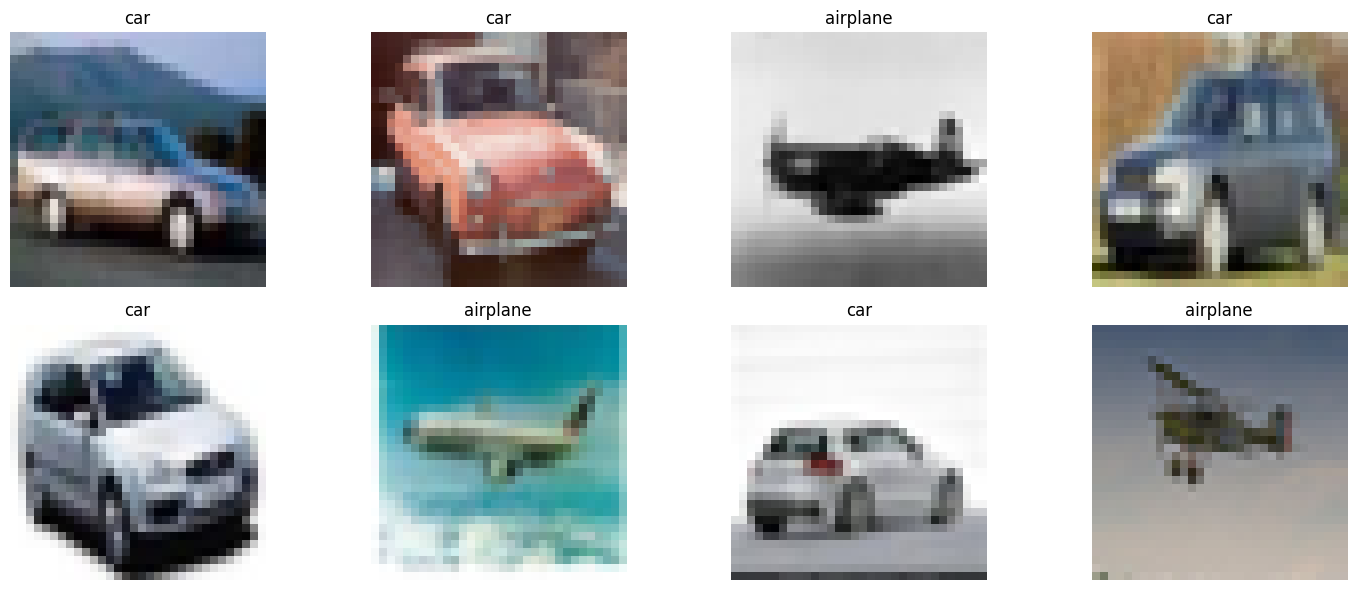

In [15]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 12
list_imgs = []
example_label = []

for i in range(8):
    list_imgs.append(x_filt[num_imagem*i])
    example_label.append(category_labels[y_filt[num_imagem*i][0]])

plot_images_grid(images=list_imgs, titles=example_label)

Dividindo dados em conjunto de treino e testes:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x_filt, y_filt, test_size=0.3, random_state=42, shuffle=True, stratify=y_filt)

Plota histograma de frequência para verificação de desbalanceamento de dados:

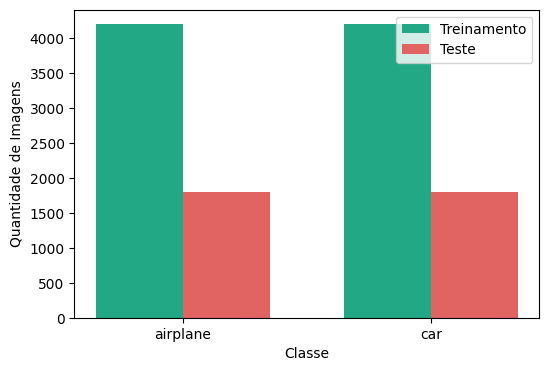

In [17]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_counts_train = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_counts_test = dict(zip(unique_test, counts_test))

class_names = ['airplane', 'car']

# Largura das barras
bar_width = 0.35

indices = np.arange(len(class_counts_train))

colors_train = plt.cm.viridis(0.6)  # Cor para o conjunto de treinamento
colors_test = plt.cm.plasma(0.6)  # Cor para o conjunto de teste

# Plotar o histograma do conjunto de treinamento
plt.figure(figsize=(6, 4))
plt.bar(indices, class_counts_train.values(), width=bar_width, label='Treinamento', color=colors_train)

# Plotar o histograma do conjunto de teste
plt.bar(indices + bar_width, class_counts_test.values(), width=bar_width, label='Teste', color=colors_test)

# Configurar o gráfico
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
plt.xticks(indices + bar_width / 2, class_names, rotation=0)
plt.legend()

plt.show()

# Modelo

Modelo inspirado na VGGNet:

In [18]:
from tensorflow.keras import layers, models, regularizers
def create_cnn_model(input_shape=(32, 32, 3), num_classes=2):
    model = Sequential()

    # Primeira camada convolucional e pooling
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Segunda camada convolucional e pooling
    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Terceira camada convolucional e pooling
    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Camada Flatten para achatar a saída e conectá-la à camada densa
    model.add(layers.Flatten())

    # Camadas densas totalmente conectadas
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    # Camada de saída
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer = SGD(learning_rate=0.001, momentum=0.95, weight_decay=1e-6)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Treinando com 5 k-folds:

In [19]:
# define o número de folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# lista para armazenar os históricos e as pontuações de cada fold
histories = []

# lista para armazenar cada modelo
models = []

# executa a validação cruzada
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    x_train2, x_val = X_train[train_index], X_train[val_index]
    y_train2, y_val = y_train[train_index], y_train[val_index]

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.0001,
        patience=6,
        verbose=1,
        mode="min",
        restore_best_weights=True,
        start_from_epoch=0,
    )

    # cria e treina o modelo
    model = create_cnn_model()
    history = model.fit(x_train2, y_train2, epochs=50, batch_size=64,
                         validation_data=(x_val, y_val), callbacks= [early_stopping], verbose=1)

    models.append(model)

    # armazenar o historico do fold
    histories.append(history.history)

    # avalia e exibe a pontuação
    score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Fold {fold + 1} - Acurácia: {score[1]:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7015 - loss: 12.2768 - val_accuracy: 0.5179 - val_loss: 12.0135
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8313 - loss: 11.1794 - val_accuracy: 0.5613 - val_loss: 11.2368
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8754 - loss: 10.1959 - val_accuracy: 0.5964 - val_loss: 10.2970
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8836 - loss: 9.3821 - val_accuracy: 0.8101 - val_loss: 9.0106
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9067 - loss: 8.5938 - val_accuracy: 0.7232 - val_loss: 8.5274
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9106 - loss: 7.9127 - val_accuracy: 0.8929 - val_loss: 7.4798
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9261 - loss: 7.2681 - val_accuracy: 0.8446 - val_loss: 6.9832
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9345 - loss: 6.6755 - val_acc

Plotando graficos de acurácia e perda para cada fold:

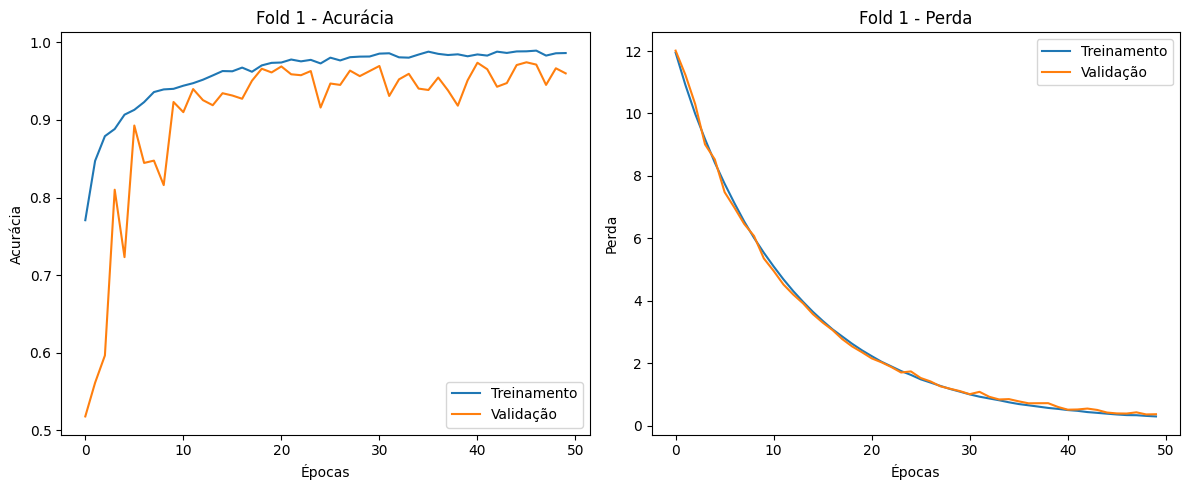

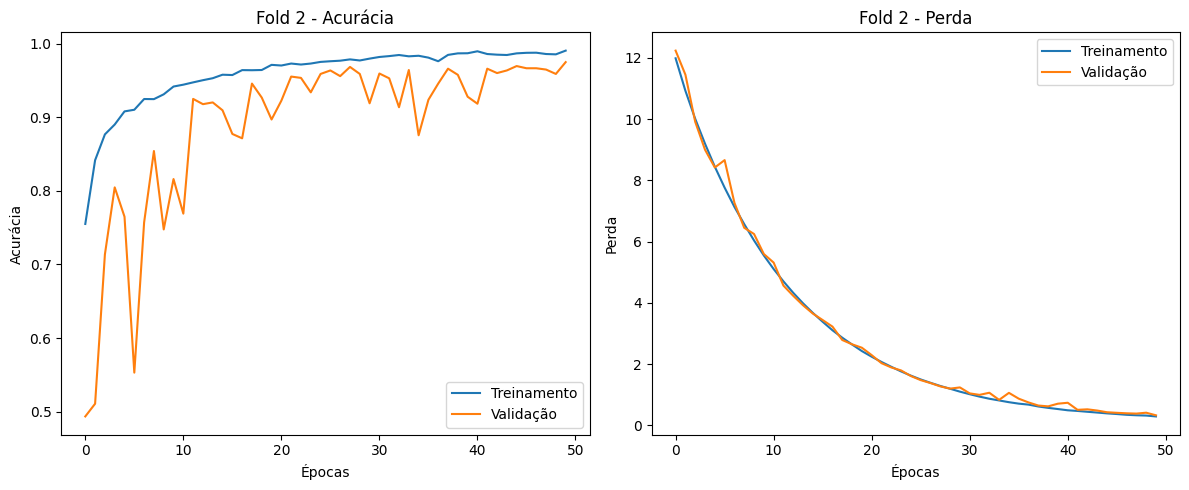

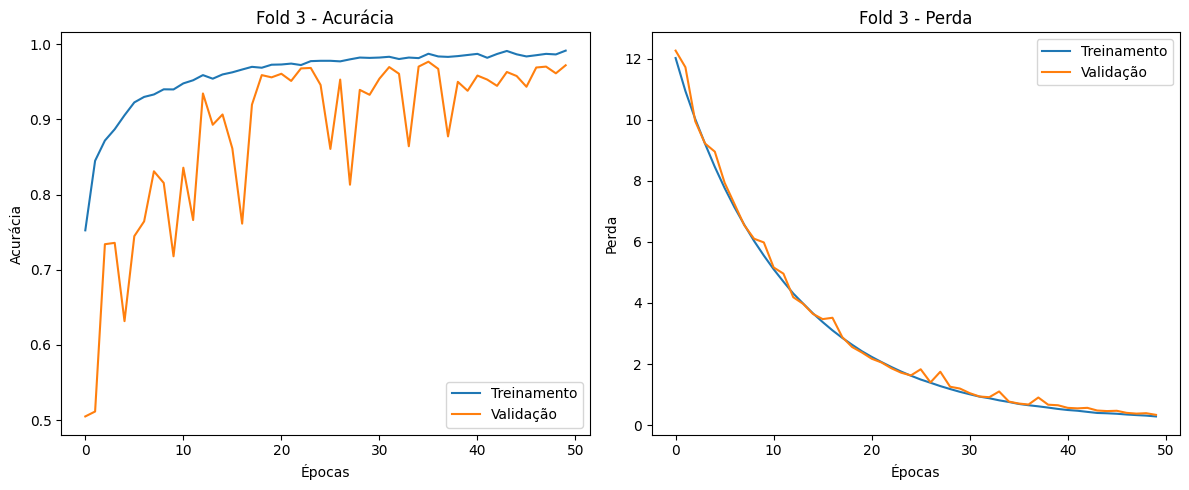

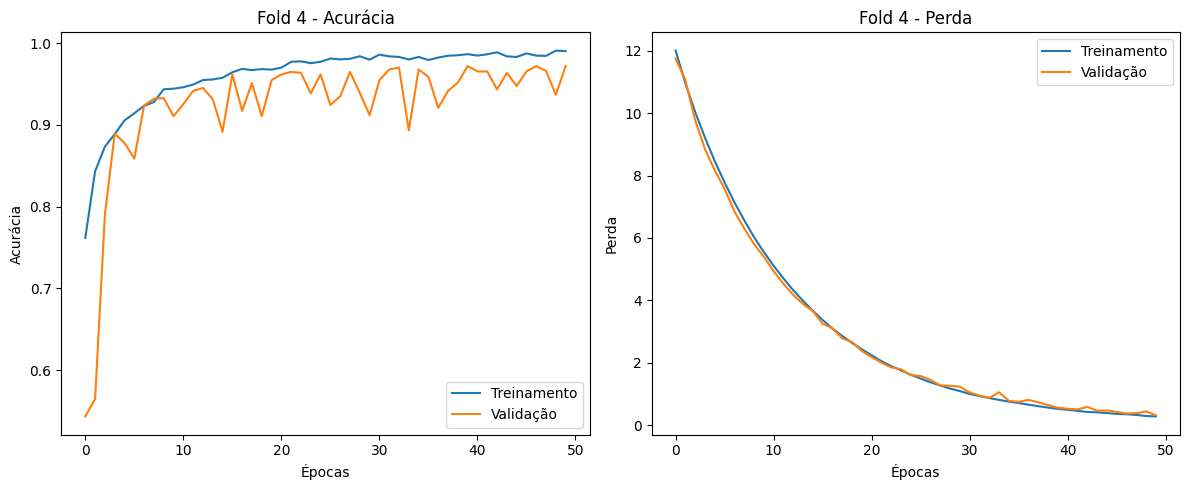

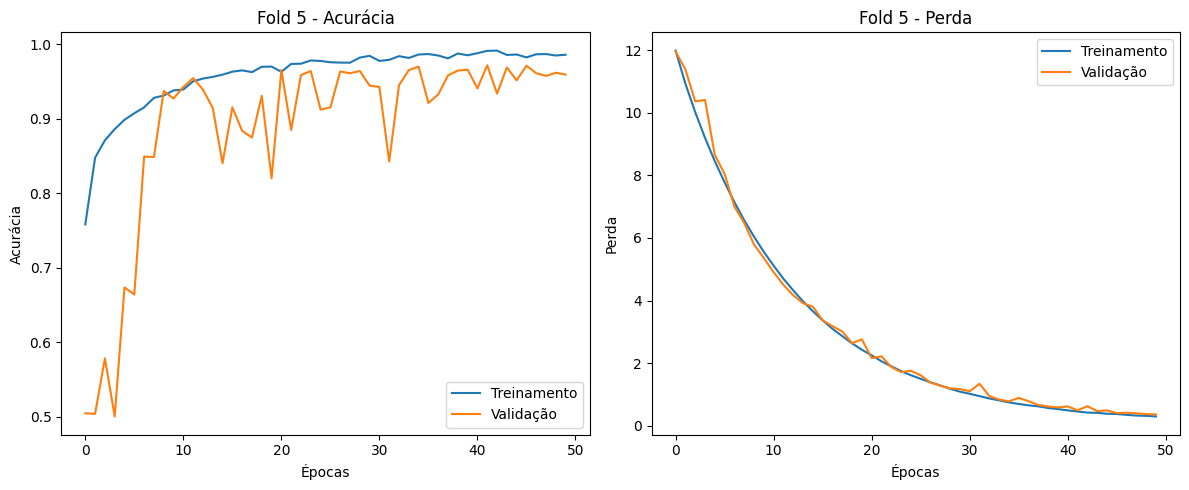

In [20]:
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 5))

    # plota acuracia
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Treinamento')
    plt.plot(history['val_accuracy'], label='Validação')
    plt.title(f'Fold {fold + 1} - Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Treinamento')
    plt.plot(history['val_loss'], label='Validação')
    plt.title(f'Fold {fold + 1} - Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

Salvando modelos:

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os

# # Diretório no Google Drive para salvar os modelos
# save_dir = '/content/drive/MyDrive/saved_models'

# # Função para salvar os modelos no Google Drive
# def save_models_drive(models):
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     for idx, model in enumerate(models):
#         model_path = os.path.join(save_dir, f'model_{idx}.h5')
#         model.save(model_path)
#         print(f"Modelo {idx} salvo no Google Drive em {model_path}")

In [ ]:
# save_models_drive(models)

Carregando modelos salvos durante a realização do exercício:

In [ ]:
# models = []
# for i in range(5):
#     models.append(load_model(f'./models/model_{i}.h5'))

Calculando matriz de confusão e métricas:

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


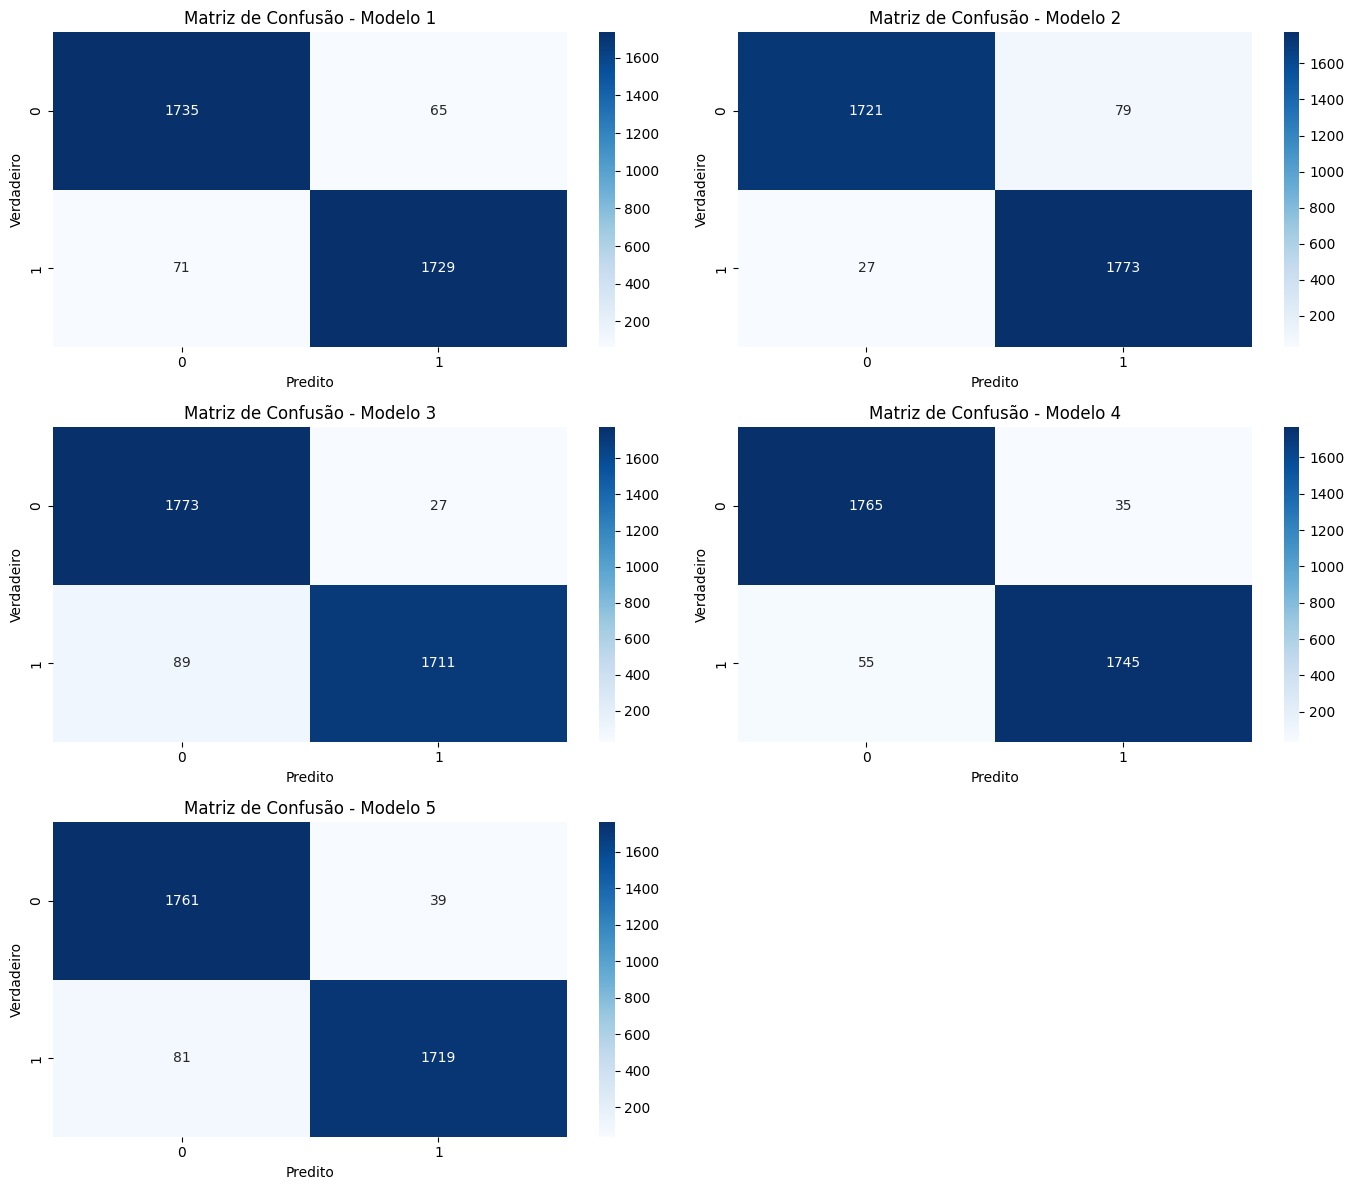

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Relatório de Classificação - Modelo 1:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1800
           1       0.96      0.96      0.96      1800

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Relatório de Classificação - Modelo 2:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1800
           1       0.96      0.98      0.97      1800

    accuracy                           0.97      3600
   macro avg       0.97      0.97      0.97      3600
weighted avg       0.97      0.97      0.97      3600

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Relatório de Classificação - Modelo 3:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     

In [21]:
num_models = len(models)

# cria a figura principal com subplots organizados em uma grade de 2x2
plt.figure(figsize=(14, 12))

for i, md in enumerate(models):
    y_pred = md.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes

    # cria a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # subplot para cada matriz de confusão
    plt.subplot(3, 2, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - Modelo {i + 1}')


plt.tight_layout()
plt.show()

# calcula e imprime o relatório de classificação para cada modelo
for i, md in enumerate(models):
    y_pred = md.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes
    report = classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(2)])
    print(f'Relatório de Classificação - Modelo {i + 1}:\n')
    print(report)